In [1]:
import os, pickle, warnings
from tqdm import tqdm
from pprint import pprint

import pandas as pd
import numpy as np

# modeling/experimentation
import mlflow
from scipy import interpolate
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# to load parameters of the experiments
from kedro.config import ConfigLoader

# utils
from joblib import Parallel, delayed
from pandas import IndexSlice as idx
from IPython.display import display

# viz
import seaborn as sns
import matplotlib.pyplot as plt

# experiments
from experiments.evaluation import eval_sets
from experiments.noaa.deterministic import NOAADeterministicExperiment
from experiments.evaluation import eval_sets as eval_conf
from spatial_interpolation.visualization import map_viz
print("Available experiment configs:",NOAADeterministicExperiment.config.config.keys())

# local utils and other imports
from spatial_interpolation.interpolators import ScipyInterpolator
from spatial_interpolation import data, utils
from spatial_interpolation.utils.experiments import conf 
from spatial_interpolation.data.load_data import get_ml_workspace
from spatial_interpolation.utils import tqdm_joblib
from spatial_interpolation.visualization import plot_interpolation, map_viz


# notebook configuration
import dotenv
warnings.simplefilter(action='ignore', category=FutureWarning)
dotenv.load_dotenv()

Available experiment configs: ['linear_set1', 'linear_set2', 'linear_set3', 'linear_set4', 'rbf_gauss_set1', 'rbf_gauss_set2', 'rbf_gauss_set3', 'rbf_gauss_set4', 'rbf_invmult_set1', 'rbf_invmult_set2', 'rbf_invmult_set3', 'rbf_invmult_set4', 'rbf_linear_set1', 'rbf_linear_set2', 'rbf_linear_set3', 'rbf_linear_set4', 'rbf_mult_set1', 'rbf_mult_set2', 'rbf_mult_set3', 'rbf_mult_set4']


True

In [2]:
# load data
experiment = NOAADeterministicExperiment("linear_set4", n_jobs=1)
config = experiment.get_config()
dataset = data.NDBCDataLoader(**config.data_loading).load()
df, gdf = dataset.buoys_data, dataset.buoys_geo
locations_within_area = gdf.loc[gdf.within(eval_conf.ndbc[config.eval_set].area)].index.get_level_values("buoy_id").unique()
df = df.loc[df.index.get_level_values("buoy_id").isin(locations_within_area)]
gdf = gdf.loc[idx[:, locations_within_area],:]
dataset = data.NDBCData(df, gdf)

train, test = dataset.split_slice(test=eval_conf.ndbc[config.eval_set].eval)
train_df = train.join()
test_df = test.join()

target = config.target
train_by_times = (
    train_df
    .reset_index()
    .rename(columns={"buoy_id": "location_id"})
    .set_index(["time", "location_id"])
    .sort_index()
    .dropna(subset=[target])
)
test_by_times = (
    test_df
    .reset_index()
    .rename(columns={"buoy_id": "location_id"})
    .set_index(["time", "location_id"])
    .sort_index()
    .dropna(subset=[target])
)


Split test obtained with dataset(s)=['buoys_data'] and shape(s)=[(80437, 14)]


In [ ]:
from pyhandy import subplotted

for fig, ax, i in subplotted(5, ncols=2, nrows=2, figsize=(10,10)):
    


In [17]:
df_times = pd.concat([train_by_times, test_by_times], axis=0)\
    .pipe(utils.resample_multiindex,"D", time_level="time")
map_args = dict(zoom_start=4.5)
map_viz.heatmap_with_time(df_times.sort_index(level="time"), "time", map_args=map_args)

In [3]:
time = "2020-05-10 05:00" #train_by_times.index.get_level_values(0)[-1]
target = config.target

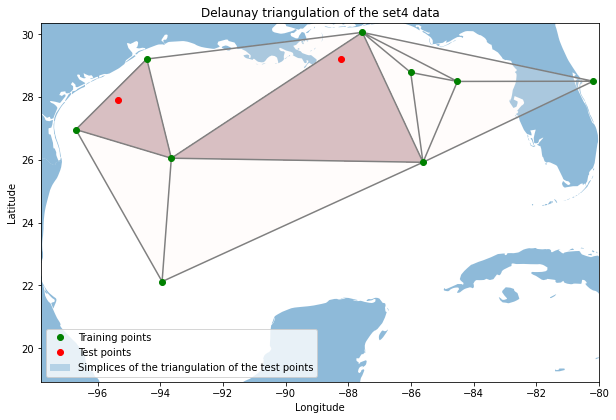

In [12]:
from scipy.spatial import Delaunay
from spatial_interpolation.data import load_world_borders

points = train_by_times.loc[time,["x","y"]].values
tri = Delaunay(points, incremental=True)
# plot the triangulation
fig,ax = plt.subplots(1,1,figsize=(10,10))
df_countries = load_world_borders()
df_countries.plot(ax=ax,alpha=0.5)
xmin, ymin, xmax, ymax = eval_sets.ndbc[config.eval_set].area.bounds
ax.set_xlim(xmin, xmax); ax.set_ylim(ymin, ymax)
# ax.triplot(points[:,0], points[:,1], tri.simplices.copy(), color="darkgrey")
ax.plot(points[:,0], points[:,1], 'o', color="green",label="Training points")
ax.set(xlabel="Longitude",ylabel="Latitude",title=f"Delaunay triangulation of the {config.eval_set} data")
ax.triplot(points[:,0], points[:,1], tri.simplices.copy(), color="grey")
test_points = test_by_times.loc[time,["x","y"]].values
ax.plot(test_points[:,0], test_points[:,1], 'o', color="red", label="Test points")
ind_tri = tri.find_simplex(test_points)
tri_mask = np.zeros(len(tri.simplices))
tri_mask[ind_tri] = 1
ax.tripcolor(
    points[:,0], points[:,1], tri.simplices.copy(), tri_mask, cmap="Reds", alpha=0.25, 
    label="Simplices of the triangulation of the test points")
closest_points = points[tri.simplices[ind_tri]][0]
ax.legend()
# ax.plot(closest_points[:,0], closest_points[:,1], 'o', color="red")

No handles with labels found to put in legend.


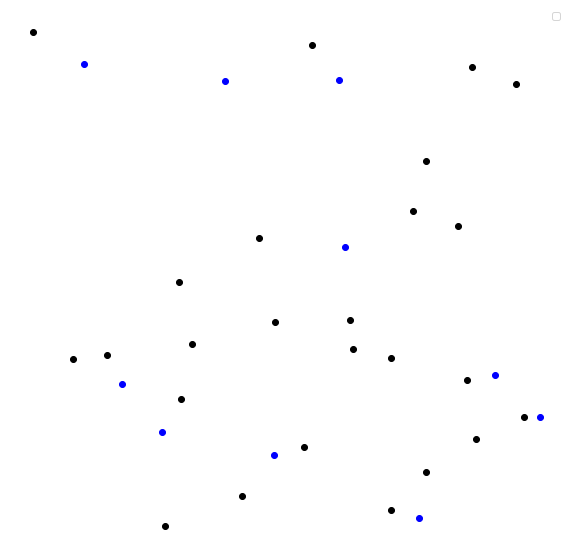

In [217]:
rand_points_X = np.random.uniform(xmin, xmax, size=(25,))
rand_points_Y = np.random.uniform(ymin, ymax, size=(25,))
rand_points = np.vstack([rand_points_X, rand_points_Y]).T
rand_points_new_X = np.random.uniform(xmin, xmax, size=(10,))
rand_points_new_Y = np.random.uniform(ymin, ymax, size=(10,))
rand_points_new = np.vstack([rand_points_new_X, rand_points_new_Y]).T
tri = Delaunay(rand_points, incremental=True)
ind_tri = tri.find_simplex(rand_points_new)
# plot the triangulation
fig,ax = plt.subplots(1,1,figsize=(10,10))
ax.plot(rand_points[:,0], rand_points[:,1], 'o', color="black") # training points
ax.plot(rand_points_new[:,0], rand_points_new[:,1], 'o', color="blue") # test points 
# ax.triplot(rand_points[:,0], rand_points[:,1], tri.simplices.copy(), color="black")
tri_mask = np.zeros(len(tri.simplices))
tri_mask[ind_tri] = 1
# ax.tripcolor(
#     rand_points[:,0], rand_points[:,1], tri.simplices.copy(), tri_mask, 
#     cmap="Reds", alpha=0.25
# ) 
closest_points = rand_points[tri.simplices[ind_tri]].reshape(-1,2)
ax.legend()
# ax.plot(closest_points[:,0], closest_points[:,1], 'o', color="red")
ax.axis('off');

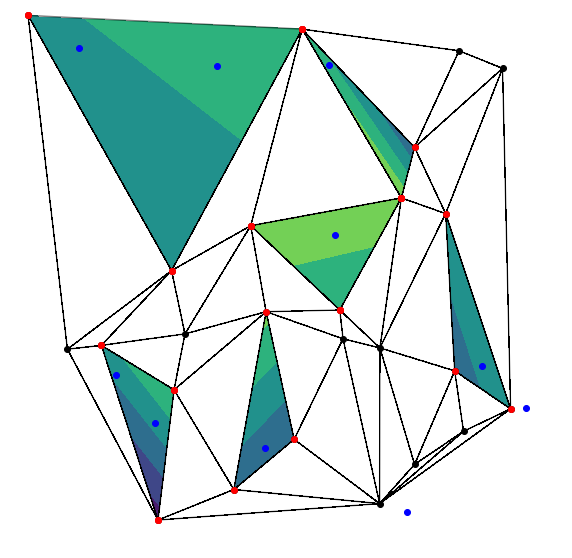

In [223]:
import matplotlib as mpl
# assign random values to each point
rand_values = np.random.uniform(0, 1, size=(len(rand_points),))
# interpolate
f = interpolate.LinearNDInterpolator(rand_points, rand_values)
# interpolate a grid
grid_x, grid_y = np.mgrid[xmin:xmax:500j, ymin:ymax:500j]
z = f(grid_x.ravel(), grid_y.ravel())
grid_z = z.reshape(grid_x.shape)
# plot the interpolation
fig,ax = plt.subplots(1,1,figsize=(10,10))
tri_mask = np.ones(len(tri.simplices)).astype(bool)
tri_mask[ind_tri] = 0
CS = ax.contourf(grid_x, grid_y, grid_z, cmap="viridis")
ax.scatter(rand_points_new[:,0], rand_points_new[:,1], marker='o', color="blue") # test points
ax.triplot(rand_points[:,0], rand_points[:,1], tri.simplices.copy(), color="black", alpha=0.5)
ax.tripcolor(
    rand_points[:,0], rand_points[:,1], tri.simplices[tri_mask], np.ones(len(tri.simplices[tri_mask])), 
    cmap=mpl.colors.ListedColormap("white"), color="black",
)
ax.scatter(rand_points[:,0], rand_points[:,1],color="black", marker='o',zorder=10)
ax.scatter(closest_points[:,0], closest_points[:,1],color="red", marker='o',zorder=11)
ax.axis('off');

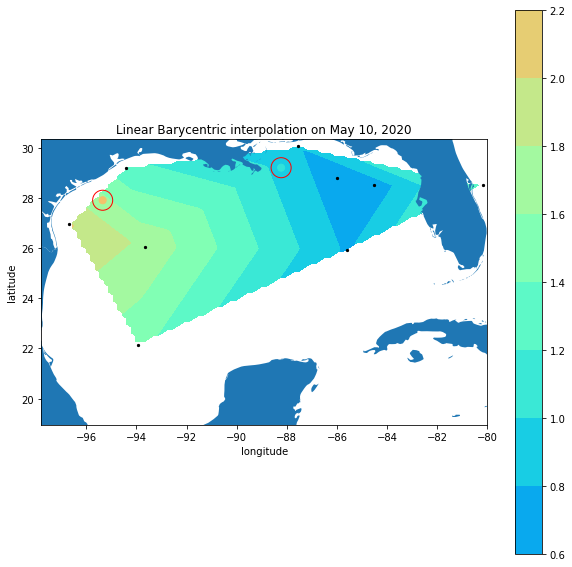

In [15]:
linear_interpolator = ScipyInterpolator(
    interpolate.LinearNDInterpolator,
    dimensions=[["x","y"]],
)
time = pd.Timestamp("2020-05-10 05:00")
linear_interpolator.fit(train_by_times.loc[time],y=target)
cm = plot_interpolation(
    train_by_times.loc[time].x,train_by_times.loc[time].y,
    test_by_times.loc[time].x,test_by_times.loc[time].y,
    test_by_times.loc[time][target],
    interpolator=linear_interpolator,
    bbox=eval_sets.ndbc[config.eval_set].area.bounds,
    radius=.4,
    title=f"Linear Barycentric interpolation on {time:%b %-d, %Y}",
    cmap="rainbow",
    zmin=0,zmax=3
)

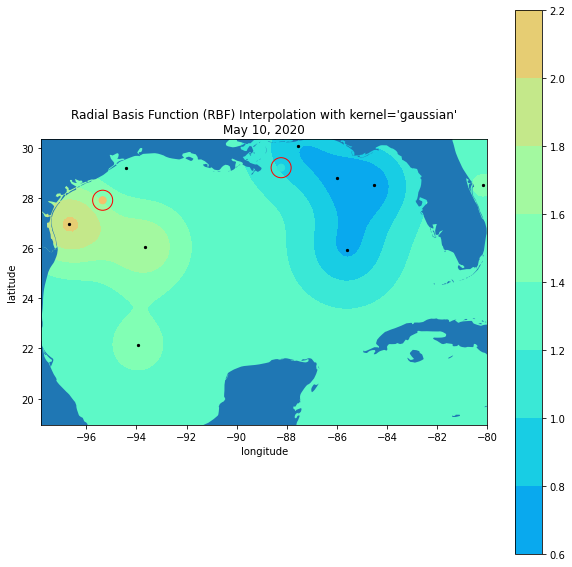

In [40]:
kernel = "gaussian"
rbf_interpolator = ScipyInterpolator(
    interpolate.RBFInterpolator,
    dimensions=[["x","y"]],
    kernel=kernel,
    epsilon=.6
)
rbf_interpolator.fit(train_by_times.loc[time],y=target)
plot_interpolation(
    train_by_times.loc[time].x,train_by_times.loc[time].y,
    test_by_times.loc[time].x,test_by_times.loc[time].y,
    test_by_times.loc[time][target],
    rbf_interpolator,
    bbox=eval_sets.ndbc[config.eval_set].area.bounds,
    radius=.4,
    cmap=cm.cmap,
    zmin=0,zmax=3,
    title=f"Radial Basis Function (RBF) Interpolation with {kernel=}\n{time:%b %-d, %Y}",
)

In [62]:
pred_dfs = []
train_times = train_by_times.index.get_level_values("time").unique()
# interpolator = ScipyInterpolator(
#     interpolate.RBFInterpolator,
#     dimensions=[["x","y"]],
#     kernel=kernel,
#     epsilon=0.3
# )
interpolator = ScipyInterpolator(
    interpolate.LinearNDInterpolator,
    dimensions=[["x","y"]],
)
for t in tqdm(test_by_times.index.get_level_values("time").unique().to_series().sample(frac=0.05)):
    if t not in train_times:
        continue
    interpolator.fit(train_by_times.loc[t],y=target)
    pred = interpolator.predict(test_by_times.loc[t])
    pred_df = pd.DataFrame({target:pred},index=test_by_times.loc[[t]].index)
    pred_dfs.append(pred_df)
pred_df = pd.concat(pred_dfs).join(test_by_times[[target]], rsuffix="_true")

  0%|          | 0/3991 [00:00<?, ?it/s]


KeyError: "None of [Index(['x', 'y'], dtype='object')] are in the [columns]"

In [27]:
true = pred_df.dropna()[target+"_true"]
pred = pred_df.dropna()[target]
print(
    f'r2: {r2_score(true,pred):.4f}',
    f'mae: {mean_absolute_error(true,pred):.4f}',
    f'rmse: {mean_squared_error(true,pred, squared=False):.4f}',
)


r2: 0.7441 mae: 0.2045 rmse: 0.3277


In [6]:
from experiments.noaa.deterministic import NOAADeterministicExperiment
from experiments.evaluation import eval_sets as eval_conf
from spatial_interpolation.visualization import map_viz
print("Available experiment configs:",NOAADeterministicExperiment.config.config.keys())

# experiment.run()

Available experiment configs: ['linear_set1', 'linear_set2', 'linear_set3', 'linear_set4', 'rbf_gauss_set1', 'rbf_gauss_set2', 'rbf_gauss_set3', 'rbf_gauss_set4', 'rbf_invmult_set1', 'rbf_invmult_set2', 'rbf_invmult_set3', 'rbf_invmult_set4', 'rbf_linear_set1', 'rbf_linear_set2', 'rbf_linear_set3', 'rbf_linear_set4', 'rbf_mult_set1', 'rbf_mult_set2', 'rbf_mult_set3', 'rbf_mult_set4']


In [12]:
for p in eval_conf.ndbc.set4.partial:
    print(p)

a
b
c


In [7]:
experiment = NOAADeterministicExperiment("linear_set4", n_jobs=1)
config = experiment.get_config()
dataset = data.NDBCDataLoader(**config.data_loading).load()
df, gdf = dataset.buoys_data, dataset.buoys_geo
locations_within_area = gdf.loc[gdf.within(eval_conf.ndbc[config.eval_set].area)].index.get_level_values("buoy_id").unique()
df = df.loc[df.index.get_level_values("buoy_id").isin(locations_within_area)]
gdf = gdf.loc[idx[:, locations_within_area],:]
dataset = data.NDBCData(df, gdf)

train, test = dataset.split_slice(test=eval_conf.ndbc[config.eval_set].eval)

Split test obtained with dataset(s)=['buoys_data'] and shape(s)=[(80437, 14)]


In [8]:
train_df = train.buoys_data.join(train
    .buoys_geo
    .sort_index()
    .reset_index()
    .drop_duplicates("buoy_id",keep="last")
    .drop(columns=["year"]) 
    .set_index("buoy_id")
).dropna(subset=[target])
test_df = test.buoys_data.join(test
    .buoys_geo
    .sort_index()
    .reset_index()
    .drop_duplicates("buoy_id",keep="last")
    .drop(columns=["year"])
    .set_index("buoy_id")
).dropna(subset=[target])

train_by_times = train_df.swaplevel(0,1).sort_index()
test_by_times = test_df.swaplevel(0,1).sort_index()

NameError: name 'target' is not defined

In [87]:
train_by_times.groupby("time").count()[target]>=4

time
2011-01-01 00:00:00    True
2011-01-01 01:00:00    True
2011-01-01 02:00:00    True
2011-01-01 03:00:00    True
2011-01-01 04:00:00    True
                       ... 
2021-12-31 19:00:00    True
2021-12-31 20:00:00    True
2021-12-31 21:00:00    True
2021-12-31 22:00:00    True
2021-12-31 23:00:00    True
Name: wave_height, Length: 95984, dtype: bool

In [54]:
map_viz.add_geodf_to_map(train_by_times.loc[time])

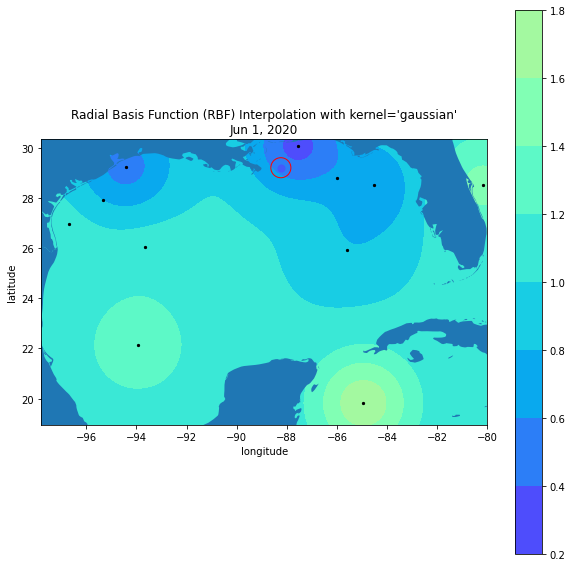

In [81]:
kernel = "gaussian"
time = pd.Timestamp("2020-06-01 22")
rbf_interpolator = ScipyInterpolator(
    interpolate.RBFInterpolator,
    dimensions=[["longitude","latitude"]],
    kernel=kernel,
    epsilon=0.5
)
rbf_interpolator.fit(train_by_times.loc[time],y=target)
plot_interpolation(
    train_by_times.loc[time,rbf_interpolator.dim_cols[0]], train_by_times.loc[time,rbf_interpolator.dim_cols[1]],
    test_by_times.loc[time, rbf_interpolator.dim_cols[0]], test_by_times.loc[time, rbf_interpolator.dim_cols[1]],
    test_by_times.loc[time][target],
    rbf_interpolator,
    bbox=eval_sets.ndbc[config.eval_set].area.bounds,
    radius=.4,
    cmap=cm.cmap,
    zmin=0,zmax=3,
    title=f"Radial Basis Function (RBF) Interpolation with {kernel=}\n{time:%b %-d, %Y}",
)

In [72]:
train_by_times.loc["2020-06-01 22",[target]]

wave_height
time                buoy_id             
2020-06-01 22:00:00 41009           1.46
                    42001            NaN
                    42002           1.09
                    42003           0.82
                    42012           0.34
                    42019           0.80
                    42020           1.06
                    42035           0.53
                    42036           0.64
                    42039           0.65
                    42055           1.39
                    42056           1.73

In [61]:
train_by_times.loc[time]

,air_temperature,average_wave_period,dew_point,dominant_wave_period,mean_wave_direction,sea_level_pressure,tide_level,visibility,water_temperature,wave_height,wind_direction,wind_gust,wind_speed,barometer,buoy_name,latitude,longitude,geometry
buoy_id,,,,,,,,,,,,,,,,,,
41009,23.733333,5.08,18.166667,7.69,0.0,1019.633333,NaN,NaN,25.550000,1.41,68.000000,9.933333,7.966667,NaN,"41009 CANAVERAL 20 NM East of Cape Canaveral, FL",28.508,-80.185,POINT (-80.18500 28.50800)
42001,NaN,NaN,NaN,NaN,NaN,1017.833333,NaN,NaN,NaN,NaN,121.833333,11.233333,8.716667,NaN,"42001 MID GULF 180 nm South of Southwest Pass,...",25.942,-89.657,POINT (-89.65700 25.94200)
42002,25.250000,5.46,19.583333,6.25,75.0,1017.683333,NaN,NaN,26.300000,1.75,108.000000,7.083333,5.733333,NaN,"Southeast of Sabine, TX.",26.055,-93.646,POINT (-93.64600 26.05500)
42003,NaN,4.37,NaN,5.26,11.0,1018.183333,NaN,NaN,25.816667,0.77,44.833333,5.300000,4.350000,NaN,"42003 E GULF 260 nm South of Panama City, FL",25.925,-85.615,POINT (-85.61500 25.92500)
42012,20.233333,3.98,11.183333,5.00,86.0,1020.933333,NaN,NaN,22.900000,0.81,36.666667,9.433333,7.566667,NaN,42012 GULF OF MEXICO,30.060,-87.548,POINT (-87.54800 30.06000)
42020,23.683333,5.53,20.716667,7.69,49.0,1019.100000,NaN,NaN,25.600000,2.02,20.500000,9.016667,7.466667,NaN,"42020 Corpus Christi, TX. 50NM Southeast of Co...",26.968,-96.693,POINT (-96.69300 26.96800)
42035,20.616667,4.36,16.133333,6.25,124.0,1020.766667,NaN,NaN,23.850000,1.26,66.833333,10.083333,8.050000,NaN,"42035 GALVESTON 22NM East of Galveston, TX.",29.232,-94.413,POINT (-94.41300 29.23200)
42036,NaN,3.82,NaN,4.17,6.0,1019.233333,NaN,NaN,NaN,0.67,25.833333,5.016667,4.050000,NaN,"42036 W. TAMPA 106NM West Northwest of Tampa, FL",28.501,-84.508,POINT (-84.50800 28.50100)
42039,NaN,3.89,NaN,5.26,107.0,1019.516667,NaN,NaN,25.600000,0.70,43.833333,6.850000,5.183333,NaN,"115NM East Southeast of Pensacola, FL",28.787,-86.007,POINT (-86.00700 28.78700)


In [60]:
rbf_interpolator.predict(train_by_times.loc[time,["longitude","latitude"]])

array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan])

In [47]:
experiment = NOAADeterministicExperiment("rbf_gauss_set1", n_jobs=1)
config = experiment.get_config()
config["interpolator_params"]

epsilon: 1
kernel: gaussian

In [ ]:
config